This notebook implements Layer-Wise Relevance Propagation as detailed in

<span style="color:blue">G. Montavon, A. Binder, S. Lapuschkin, W. Samek, K.-R. MüllerLayer-wise Relevance Propagation: An Overviewin Explainable AI: Interpreting, Explaining and Visualizing Deep Learning, Springer LNCS, vol. 11700, 2019.</span>

It borrows heavily from https://git.tu-berlin.de/gmontavon/lrp-tutorial.

In [1]:
import os 
os.chdir ('/projects/bbhj/asinha15/VLQ-NN-Reweighting/main')

In [2]:
import numpy as np
import copy
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from Data import CSVData

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
model_path = '/projects/bbhj/asinha15/VLQ-NN-Reweighting/main/trained_models/model_scripted7.pt'
model = torch.jit.load(model_path).to(device)
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (Linear0): RecursiveScriptModule(original_name=Linear)
  (Activation0): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear1): RecursiveScriptModule(original_name=Linear)
  (Activation1): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear2): RecursiveScriptModule(original_name=Linear)
  (Activation2): RecursiveScriptModule(original_name=LeakyReLU)
  (Linear_last): RecursiveScriptModule(original_name=Linear)
)

In [5]:
features = ['mode',
'Msim',
'Gsim',
'weight',
'pz_in1',
'pid_in1', 
'pz_in2',
'pid_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'pid_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'pid_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'pid_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'pid_out4',
'Mtarget',
'Gtarget',]
label = 'f_rwt'
features_to_rescale = ['Msim',
'Gsim',
'pz_in1', 
'pz_in2',
'px_out1',
'py_out1',
'pz_out1',
'e_out1',
'px_out2',
'py_out2',
'pz_out2',
'e_out2',
'px_out3',
'py_out3',
'pz_out3',
'e_out3',
'px_out4',
'py_out4',
'pz_out4',
'e_out4',
'Mtarget',
'Gtarget']

train_data = CSVData(batch_size=1024, features_name=features, labels_name=label, features_to_rescale= features_to_rescale, file_names=['/projects/bbhj/asinha15/train_' + str(i)+'.csv' for i in range(0,10)])

In [6]:
X, Y = train_data.load_data_many()
X = np.array(X)
Y = np.log(np.array(Y))

In [7]:
W = []
B = []
for name, param in model.named_parameters():
    if 'weight' in name:
        W.append(param.cpu().detach().numpy().transpose())
    elif 'bias' in name:
        B.append(param.cpu().detach().numpy())
L = len(W)

In [8]:
A = [X]+[None]*L
for l in range(L-1):
    A[l+1] = np.maximum(0.01*(A[l].dot(W[l])+B[l]),A[l].dot(W[l])+B[l]) #forward pass with LeakyRelu activation
A[L] = A[L-1].dot(W[L-1])+B[L-1]

In [9]:
def rho(w,l):  
    return w #+ [None,0.1,0.0,0.0][l] * w
def incr(z,l): 
    return z #+ [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [10]:
R = [None]*L + [A[L]*Y[:, None]] #Set the top layer relevance scores to top layer activation * label

In [11]:
R

[None,
 None,
 None,
 None,
 array([[ 2.26386117],
        [ 2.67689414],
        [ 2.60682066],
        ...,
        [ 6.63192547],
        [20.13588559],
        [27.41427009]])]

Following the steps for propagation:
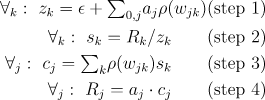

In [12]:
for l in range(0,L)[::-1]:
    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)                # step 1
    s = R[l+1] / z                           # step 2
    c = w.dot(s.transpose()).transpose()     # step 3
    R[l] = A[l]*c                            # step 4

In [13]:
matplotlib.rcParams.update({'axes.titlesize': 'xx-large'})
matplotlib.rcParams.update({'axes.labelsize': 'xx-large'})

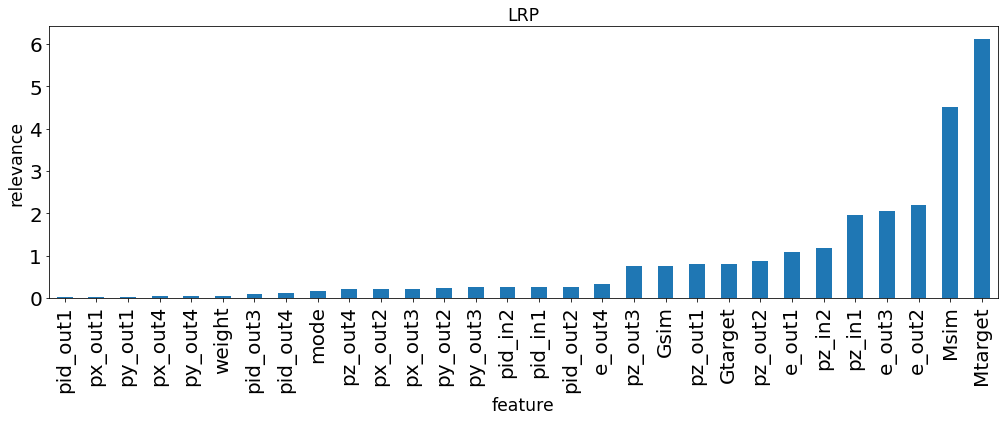

In [23]:
df = pd.DataFrame(np.array([features, np.mean(np.abs(R[0]/Y[:, np.newaxis]), axis=0)]).transpose())
df.columns=['feature', 'relevance']
df.relevance = df.relevance.astype(float)
df = df.sort_values(by=['relevance'])
df.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='LRP', figsize=(17, 5))
del df

Now we can display the results on a per-mode basis.

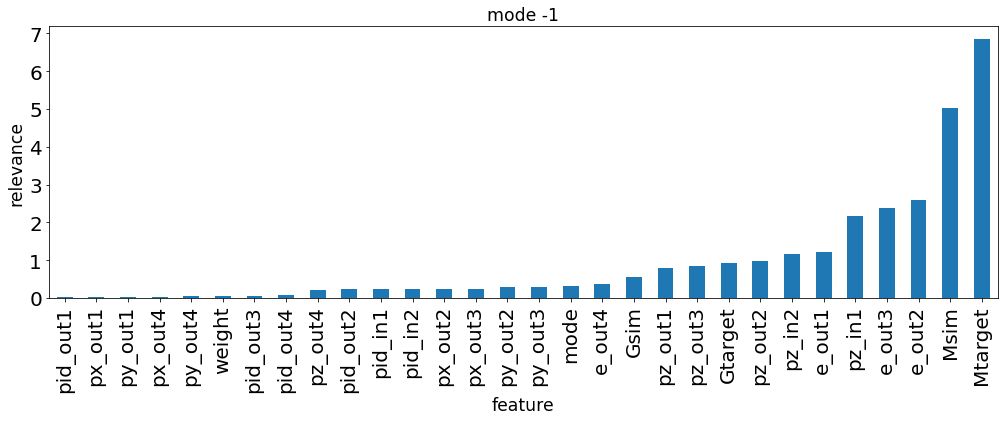

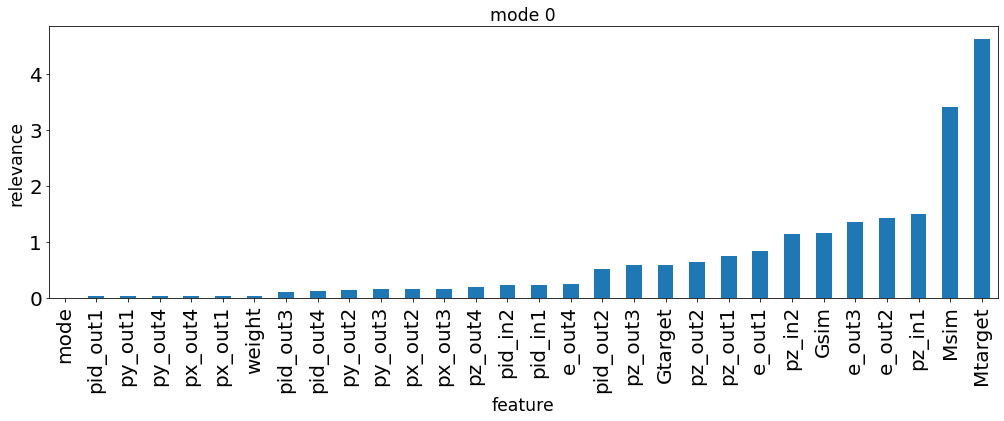

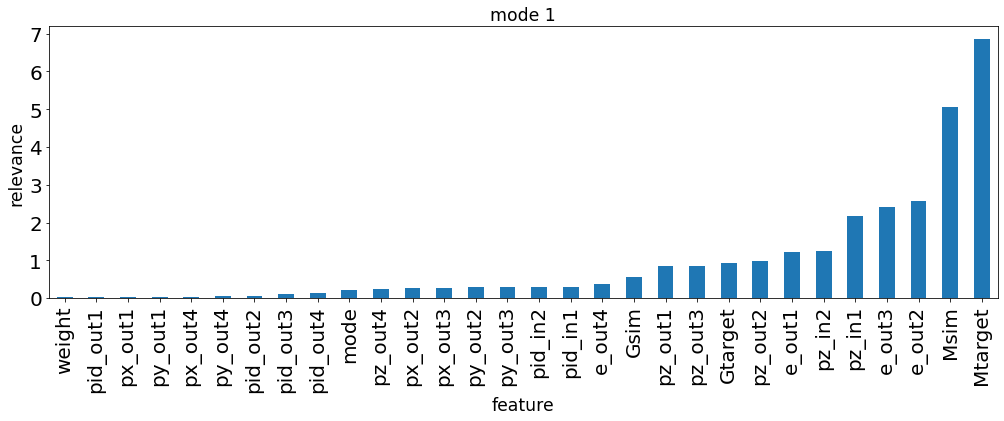

In [24]:
df_all = pd.DataFrame(X)
df_all.columns = features
rels = R[0]/Y[:, np.newaxis]
modes = [-1,0,1]
for i, b in enumerate(modes):
    idx = df_all.index[df_all['mode']==b].tolist()
    rel_mode = pd.DataFrame(np.array([features, np.mean(np.abs([rels[idxi][:] for idxi in idx]), axis=0)])).transpose()
    rel_mode.columns = ['feature', 'relevance']
    rel_mode.relevance = rel_mode.relevance.astype(float)
    rel_mode = rel_mode.sort_values(by=['relevance'])
    rel_mode.plot.bar(x='feature', y='relevance', legend=False, fontsize=20, xlabel='feature', ylabel='relevance', title='mode '+str(b), figsize=(17, 5))
    del rel_mode
del df_all, rels

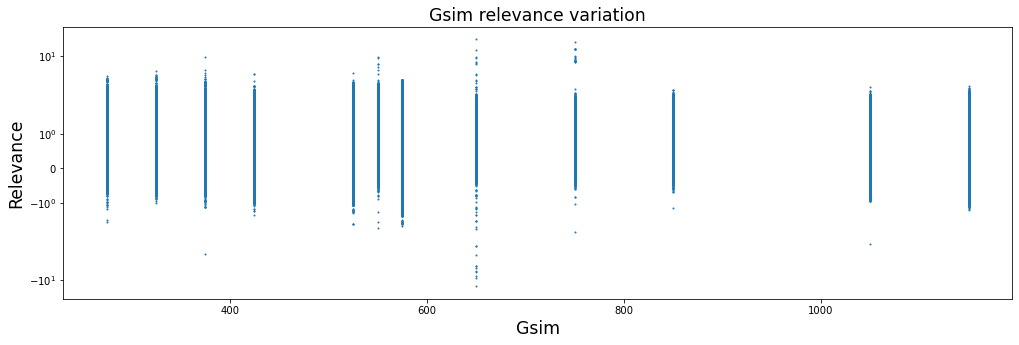

In [34]:
plt.figure(figsize=(17, 5))
plt.title('Gsim relevance variation')
plt.scatter(X[:,2], R[0][:,2]/Y, s=1)
plt.xlabel('Gsim')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()

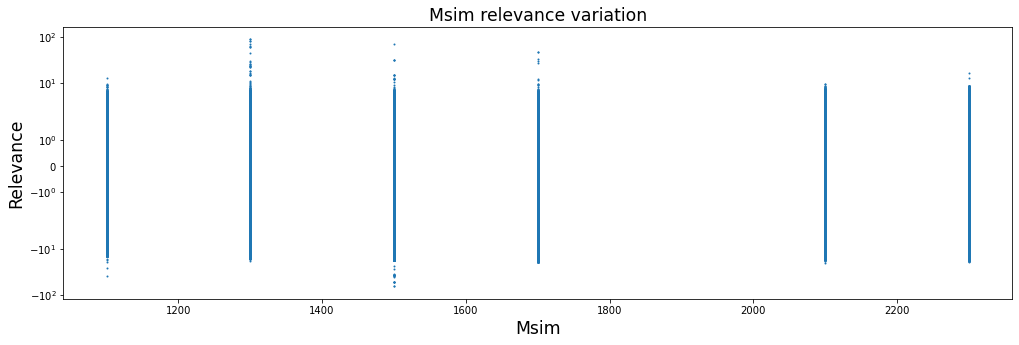

In [33]:
plt.figure(figsize=(17, 5))
plt.title('Msim relevance variation')
plt.scatter(X[:,1], R[0][:,1]/Y, s=1)
plt.xlabel('Msim')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()

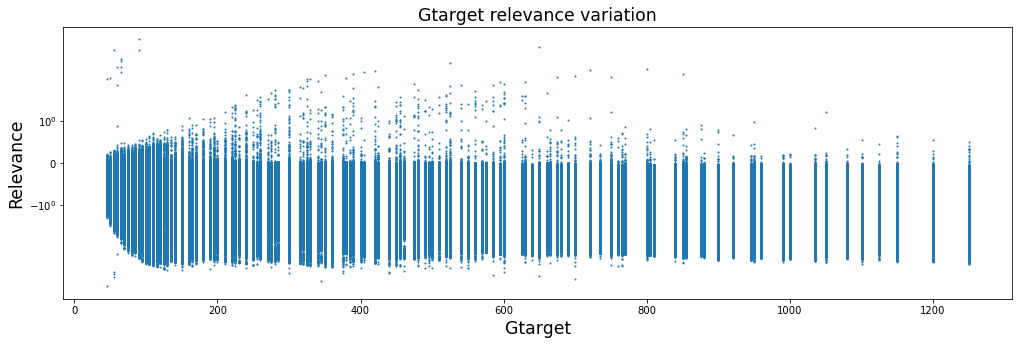

In [32]:
plt.figure(figsize=(17, 5))
plt.title('Gtarget relevance variation')
plt.scatter(X[:,29], R[0][:,29]/Y, s=1)
plt.xlabel('Gtarget')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()

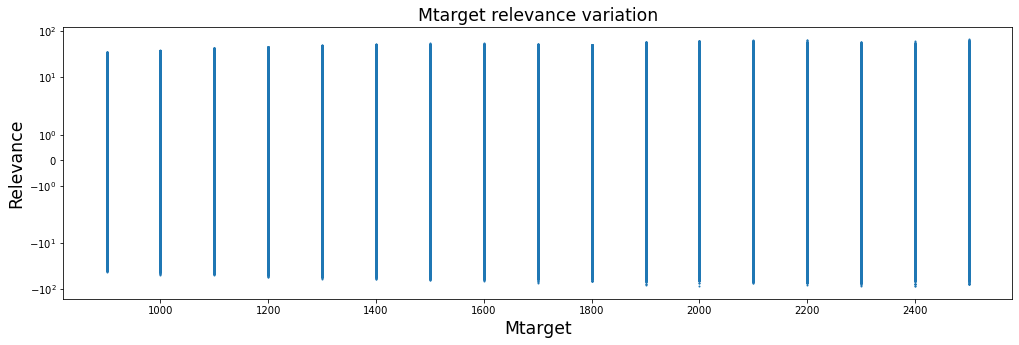

In [31]:
plt.figure(figsize=(17, 5))
plt.title('Mtarget relevance variation')
plt.scatter(X[:,28], R[0][:,28]/Y, s=1)
plt.xlabel('Mtarget')
plt.ylabel('Relevance')
plt.yscale('symlog')
plt.show()